In [1]:
import os
import xarray as xr
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# Introduction

Make river input scenarios for OF800

Questions (maybe for Miljødirektoratet) & future improvement needs:
* Currently don't do any scenarios for Sweden. Should we do something simple there?
* Wrong area-scaling of discharge used in the past. Therefore baseline inputs are over-estimated slightly, especially in vassdragsområder with a large proportion of sea.
* At the same time, underestimate inputs by assuming concentration in hoved elv is representative of the whole vassdragsområde. Future improvement: use scaling ratio for concentration for baseline, based on TEOTIL3 comparison of hovedelv vs whole vassdragsområde.

Other notes:
* Have checked, and the hovedelv regine used are upstream of any RA inputs that Phil adds on in a post-processing step. (This must have been the rationale for adding these RA separately, as they were not captured by the monitoring point)

More general things that need improving in the modelling:
* Sewage inputs to OF800 need updating in several ways: make compatible with TEOTIl. E.g. add all stations present in TEOTIL, same fluxes, and same fractionation of TN (into DIN and DON) as TEOTIL. E.g. Mjøndalen Bru not included at the moment, and it's a fairly substantial RA downstream of the Drammenselva monitoring point.
* Location of river inputs could be better-resolved/should be reconsidered.


# User input

In [2]:
# User input
# Version number
v = 3  # For file naming

# Filepath to baseline daily river data
fpath_baseline_data = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini_rivers_v9_1990_2022_stage1data.nc"

# Filepath to river metadata csvs
real_riv_metadata = r"../data/real_river_metadata.csv"

# TEOTIL results (annual source apportionment)
# Baseline and scenario data
teotil_res_csv_fpath = (
    r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/teotil3_oslomod_results_2017-2019.csv"
)

# Start and end year to summarise TEOTIL data over (inclusive??)
start_year = 2017
end_year = 2019

# Folders for output files
netcdf_outfolder = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios"
summary_csv_folder = r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/summary_csvs"
fig_folder = r"../output/plots/v3"

# REAL river numbers to use
# full OF800 domain: model rivs 5-29 incl. Drop Sweden, becomes 7 to 29 (incl.). Real rivs 4 to 23.
# (v3: scenarios generated for vassdragsområder 001 (real riv 6-Tista, model riv 7) to 017 (real riv 23-Kammerfosselva, model riv 29), i.e. full OF800 domain excl. sweden)
oslofjord_riv_nos = range(6, 24)  # Whole OF domain, excluding 2 Swedish rivers
print(f"Generating scenarios for real rivers:\n{list(oslofjord_riv_nos)}")

# Species to alter in the scenarios (teotil3 species; mapping to of800 species done below)
# choose from ['din', 'tdp', 'ss', 'toc', 'ton', 'totn', 'totp', 'tpp']
t3_par_list = ['din', 'tdp', 'toc', 'ton', 'totn', 'totp', 'tpp', 'ss']

Generating scenarios for real rivers:
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


# Set up & read in river metadata

In [3]:
# Dictionary to map from TEOTIL3 variable name to OF800 variable names
# We assume the same % reduction across all of800 variable names returned for a given
# TEOTIL3 variable name
# N.B. river_TIP is not used downstream in OF800, so do not include in the mapping.
var_mapping_teotil3_to_of800 = {
    'din': ['river_NH4N', 'river_NO3NO2N'],
    'ton': ['river_DON', 'river_PON'],
    'totn': ['river_TOTN'],
    'totp': ['river_TOTP'],
    'tdp': ['river_SRP', 'river_DOP'],
    'tpp': ['river_POP'],  # PIP isn't used in Martini, so don't worry about
    'toc': ['river_DOC', 'river_POC'],
    #'ss': ['river_SPM']#  # SPM is in a separate netcdf file. Just provide Phil with factors
}

# Calculate start date (inclusive), end date (day after last day)
start_date = dt.datetime(start_year, 1, 1)
end_date = dt.datetime(end_year, 12, 31)
end_date += pd.Timedelta(days=1)

# River chemistry metadata
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})
# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_riv_nos)]
# Add 'total' row for use later
river_meta_df.loc['Total', ['river_name', 'Regine', 'Regine_to_sea', 'Vassom']] = 'Total'
river_meta_df.query('real_river in @oslofjord_riv_nos')

,river_name,Outflow_lat,Outflow_lon,Regine,Regine_to_sea,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment
real_river,,,,,,,,,,,,
6.0,Tista,59.119,11.370,001.A1,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN
7.0,Glomma,59.206,10.953,002.A51,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,Monitoring point upstream of Sarpsborg RA. So ...
8.0,Mosseelva,59.439,10.662,003.A1,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN
9.0,Hølenelva,59.523,10.690,004.A0,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN
10.0,Årungen,59.720,10.728,005.3A,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN
11.0,Akerselva,59.908,10.756,006.A10,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN
12.0,Lysakerelva,59.914,10.640,007.A0,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN
13.0,Sandvikselva,59.890,10.523,008.A11,008.A11,008.,279.0,311.0,311.0,226.0,11.0,NaN
14.0,Åros,59.704,10.519,009.A0,009.A0,009.,215.0,253.0,NaN,NaN,18.0,NaN


# TEOTIL source apportionment

## Read in data

TEOTIL columns:
* 'year',
* 'regine',
* 'regine_down',
* 'accum_agriculture-background_din_kg',
* 'accum_agriculture-background_ss_kg',
* 'accum_agriculture-background_tdp_kg',
* 'accum_agriculture-background_toc_kg',
* 'accum_agriculture-background_ton_kg',
* 'accum_agriculture-background_totn_kg',
* 'accum_agriculture-background_totp_kg',
* 'accum_agriculture-background_tpp_kg',
* ... repeat for all the other sources, e.g. instead of 'agriculture-background', have 'urban', 'wood', etc.
* ... repeat with local_ instead of accum_ for local inputs to the regine, rather than accumulated upstream inputs. Here, we're interested in accumulated upstream inpust.

i.e. param choices are totn, din, ton, ss, totp, tdp, tpp, toc

In [4]:
def extract_source(col_name):
    """
    Function to rename teotil columns
    """
    parts = col_name.split('_')
    return parts[1]


def read_teotil_data(teotil_data_fpath, par):
    """
    Function to read raw TEOTIL data, pick the columns of interest (just accumulated inputs
    from all upstream areas), rename columns, truncate to the period of interest.

    Do this for areas upstream of a given regine of interest
    """
    df = pd.read_csv(teotil_data_fpath)

    # Just pick out accumulated inputs (from all upstream areas) for the outflow reginer of interest
    # Also just pick columns for the single parameter of interest
    cols = ["scenario", "regine", "year"] + [
        col for col in df.columns if f"_{par}_" in col and col.startswith("accum")
    ]
    df = df.loc[df['regine'].isin(river_meta_df['Regine'])][cols]

    # Truncate to start of model period
    df = df.loc[df['year'] >= start_year]
    df = df.loc[df['year'] <= end_year]

    # Replace 'regine' index with river numbers, for easier matching to the river data
    mapping_dict = river_meta_df.reset_index().set_index('Regine')['real_river'].to_dict()
    df.index = df['regine'].map(mapping_dict)
    df.index.name = 'real_river'
    df = df.drop('regine', axis=1)

    # Rename columns
    cols_to_exclude = ['scenario', 'year']
    new_col_names_dict = {col: extract_source(col) for col in df.columns if col not in cols_to_exclude}
    new_col_names = cols_to_exclude + list(new_col_names_dict.values())
    col_dict = dict(zip(df.columns, new_col_names))
    df = df.rename(columns=col_dict)

    return df


def teotil_average_over_years(df):
    """
    Average over all years to get a single value per main catchment area (or real river).
    Replace 'regine' index with river numbers
    """

    # Average over the year column per regine
    group_col = df.index.name
    av_df = df.reset_index().groupby(group_col).mean().drop('year', axis=1)

    return av_df



In [26]:
# Read baseline and scenario TEOTIL data (units kg/yr) and average over time
teotil_av_df_dict = {}  # key: (scenario, par), returns df of time-averaged loads with real_river index, one column per source

natural_cols = ['agriculture-background', 'lake', 'upland', 'wood']
# human_cols = ['agriculture', 'aquaculture', 'industry', 'large-wastewater', 'spredt', 'urban', ]

# Make list of scenarios, for looping later
scenario_list = []

for i, par in enumerate(t3_par_list):
    tmp_teotil_df = read_teotil_data(teotil_res_csv_fpath, par)

    unique_scenarios = tmp_teotil_df['scenario'].unique()

    for scenario in unique_scenarios:
        # Select rows where the 'scenario' column matches the current scenario
        tmp_scenario_df = tmp_teotil_df[tmp_teotil_df['scenario'] == scenario]
        tmp_scenario_df = tmp_scenario_df.drop('scenario', axis=1)

        tmp_teotil_av_df = teotil_average_over_years(tmp_scenario_df)
        teotil_av_df_dict[(scenario, par)] = tmp_teotil_av_df

        # Populate scenario list (just once)
        if i == 0:
            scenario_list.append(scenario)

        # Print for QC
        if par == 'ss':
            print(f'------------Scenario: {scenario} ---------')
            print(tmp_scenario_df.loc[7, :].drop('year', axis=1).sum(axis=1) / 1000)  # tonnes/yr for Glomma

    # Add no human inputs scenario, by dropping all columns which are human
    # Also drop any columns which aren't present for this param
    # In the code below, these are then summed
    natural_df = teotil_av_df_dict[('Baseline', par)].copy()
    cols_in_nat_df = natural_df.columns
    keep_cols = list(set(natural_cols) & set(cols_in_nat_df))
    natural_df = natural_df[keep_cols]
    teotil_av_df_dict[('Natural', par)] = natural_df

    # Print for QC
    if par == 'ss':
        print(f'------------Scenario: Natural ---------')
        print(natural_df.loc[7, :].sum() / 1000)  # tonnes/yr for Glomma

# Drop baseline from scenario_list for future use, and add Natural
scenario_list.remove('Baseline')
scenario_list += ['Natural']
print(scenario_list)

------------Scenario: Baseline ---------
real_river
7.0    145049.064101
7.0    164304.529149
7.0    163799.740292
dtype: float64
------------Scenario: Scenario_A ---------
real_river
7.0    53335.926605
7.0    59751.273466
7.0    59569.826321
dtype: float64
------------Scenario: Scenario_B ---------
real_river
7.0    38283.428014
7.0    42433.094616
7.0    42310.920011
dtype: float64
------------Scenario: Natural ---------
13795.27844866457
['Scenario_A', 'Scenario_B', 'Natural']


## Load reductions

In [38]:
# Work out overall TEOTIL3 loads (tonnes/yr) and reductions

scen_summary_df_dict = {}  # Key: par

for par in t3_par_list:
    tot_li = []
    for scenario in ['Baseline'] + scenario_list:
        of_total_s = teotil_av_df_dict[(scenario, par)].copy()
        of_total_s = of_total_s.sum(axis=1) / 1000
        of_total_s.name = scenario
        tot_li.append(of_total_s)

    tot_df = pd.concat(tot_li, axis=1)
    # Add river name
    tot_df['river_name'] = tot_df.index.map(river_meta_df['river_name'])
    tot_df.loc['Whole OF', :] = tot_df.sum(axis=0)
    tot_df.loc['Whole OF', 'river_name'] = 'Whole OF'

    # Calculate factors and % redutions
    for scenario in scenario_list:
        tot_df[f'f_red_{scenario}'] = tot_df[f'{scenario}'] / tot_df['Baseline']
        tot_df[f'Percent_reduction_{scenario}'] = (100 * (1 - tot_df[f'f_red_{scenario}'])).round(2)

    scen_summary_df_dict[par] = tot_df

    # Save to csv
    fpath = os.path.join(summary_csv_folder, f"river_input_reduction_factors_{par}.csv")
    tot_df.to_csv(fpath, index=True)

scen_summary_df_dict['din']

,Baseline,Scenario_A,Scenario_B,Natural,river_name,f_red_Scenario_A,Percent_reduction_Scenario_A,f_red_Scenario_B,Percent_reduction_Scenario_B,f_red_Natural,Percent_reduction_Natural
real_river,,,,,,,,,,,
6.0,371.447101,359.390419,275.721181,76.778146,Tista,0.967541,3.25,0.742289,25.77,0.206700,79.33
7.0,9543.466110,8647.866688,6857.860762,1595.233709,Glomma,0.906156,9.38,0.718592,28.14,0.167155,83.28
8.0,235.297826,231.286863,180.483841,42.526991,Mosseelva,0.982954,1.70,0.767044,23.30,0.180737,81.93
9.0,175.334598,170.386060,129.379245,19.369083,Hølenelva,0.971777,2.82,0.737899,26.21,0.110469,88.95
10.0,61.799531,60.296928,47.048101,6.611004,Årungen,0.975686,2.43,0.761302,23.87,0.106975,89.30
11.0,36.979296,36.830038,35.069431,13.903058,Akerselva,0.995964,0.40,0.948353,5.16,0.375969,62.40
12.0,33.832345,33.475422,30.813888,13.440163,Lysakerelva,0.989450,1.05,0.910782,8.92,0.397258,60.27
13.0,69.879051,68.809331,61.270822,14.153049,Sandvikselva,0.984692,1.53,0.876812,12.32,0.202536,79.75
14.0,69.772272,67.610049,54.277904,9.969712,Åros,0.969010,3.10,0.777929,22.21,0.142889,85.71


In [28]:
# SS summary for Phil (not included in netcdfs, just flat reduction factor
scen_summary_df_dict['ss'].loc['Whole OF', :]

Baseline                        275714.105323
Scenario_A                      103946.655239
Scenario_B                       78058.673052
Natural                          22658.008995
river_name                           Whole OF
f_red_Scenario_A                     0.377009
Percent_reduction_Scenario_A             62.3
f_red_Scenario_B                     0.283115
Percent_reduction_Scenario_B            71.69
f_red_Natural                        0.082179
Percent_reduction_Natural               91.78
Name: Whole OF, dtype: object

In [8]:
# # Quick manual check

# riv_no = 7
# par = 'din'

# test = teotil_av_df_dict[('Baseline', par)].copy().loc[riv_no, :]/1000  # tonnes/yr
# print(f"Baseline: {test.sum().round(2)}")

# test = teotil_av_df_dict[('Scenario_A', par)].copy().loc[riv_no, :]/1000  # tonnes/yr
# print(f"Scenario_A: {test.sum().round(2)}")

# test = teotil_av_df_dict[('Scenario_B', par)].copy().loc[riv_no, :]/1000  # tonnes/yr
# print(f"Scenario_B: {test.sum().round(2)}")

# Calculate new daily concentrations

## Read in daily river data netcdf & tidy

In [29]:
# If present, drop 'ss' from t3_par_li
if 'ss' in t3_par_list:
    t3_par_li_no_ss = t3_par_list.copy()
    t3_par_li_no_ss.remove('ss')

# Make list of of800 chem variables to be updated (for slicing baseline netcdf)
of800_chem_var_li = []
for par in t3_par_li_no_ss:
    of800_chem_var_li.extend(var_mapping_teotil3_to_of800[par])

bsl_ds = xr.open_dataset(fpath_baseline_data)

# Convert to dataframe for easier manipulation (by me!)
bsl_conc_df = bsl_ds.to_dataframe().loc[:, of800_chem_var_li]

# Convert all numeric columns to float64 (chem cols were float32)
bsl_conc_df[of800_chem_var_li] = bsl_conc_df[of800_chem_var_li].astype(float)

bsl_conc_df = bsl_conc_df.reset_index()  # Drop multiindex

# Select just the Oslofjord rivers
bsl_conc_df = bsl_conc_df[bsl_conc_df['real_river'].isin(oslofjord_riv_nos)]

# Truncate to start and end date
bsl_conc_df = bsl_conc_df.query('@start_date <= river_time <= @end_date')

bsl_conc_df.tail()

,river_time,real_river,river_NH4N,river_NO3NO2N,river_SRP,river_DOP,river_DOC,river_POC,river_DON,river_PON,river_TOTN,river_TOTP,river_POP
427302,2019-12-31 12:00:00,19.0,17.880396,641.613220,22.077616,3.087059,6.468129,182.756927,153.409073,17.634790,830.697632,27.266380,2.101705
427303,2019-12-31 12:00:00,20.0,210.453171,1744.519653,21.585827,5.090003,6.038612,167.604385,0.000000,15.322986,1970.295898,41.346577,1.927450
427304,2019-12-31 12:00:00,21.0,39.965130,208.524704,2.946716,1.540593,4.284637,247.061371,143.308258,15.844756,407.786743,7.328516,2.841206
427305,2019-12-31 12:00:00,22.0,8.145335,158.108063,1.807409,0.994220,2.876943,151.097061,133.921066,14.229559,314.533264,4.539244,1.737616
427306,2019-12-31 12:00:00,23.0,9.472936,147.992722,1.941060,2.930876,5.722866,113.920692,199.993958,11.347857,368.910522,6.182024,1.310088


In [10]:
# # Explore for specific rivers/times
# temp = conc_df.loc[conc_df['real_river'] == 14, ['river_time', 'river_NO3NO2N']]
# temp

## Calculate scenario concentrations

In [30]:
scen_conc_dict = {}  # key: scenario, returns df of scenario concentration data for of800 vars

for scenario in scenario_list:

    # New conc df for updating with scenario data
    scen_conc_df = bsl_conc_df.copy()

    for t3_par in t3_par_li_no_ss:

        # Extract series of reduction factors for this scenario and teotil3 par (index = real_river)
        river_factors = scen_summary_df_dict[t3_par].copy()
        # Just select column with factors
        river_factors = river_factors[f"f_red_{scenario}"]
        # Drop Osloford total row
        river_factors = river_factors.drop('Whole OF', axis=0)

        # Multiply baseline conc by the reduction factor
        for of800_par in var_mapping_teotil3_to_of800[t3_par]:
            scen_conc_df[of800_par] = bsl_conc_df[of800_par] * bsl_conc_df['real_river'].map(river_factors)

    # Bit of QC - check for NaNs
    if scen_conc_df.isna().sum().sum() > 0:
        print(f"{scenario}, {par} has NaNs. Needs fixing!")

    scen_conc_dict[scenario] = scen_conc_df

In [31]:
# Quick manual check for QC

riv = 7
t3_par = 'tdp'
scen = 'Scenario_A'

# Baseline data
test_df = bsl_conc_df.copy()
test_df.loc[test_df['real_river'] == riv].head()

,river_time,real_river,river_NH4N,river_NO3NO2N,river_SRP,river_DOP,river_DOC,river_POC,river_DON,river_PON,river_TOTN,river_TOTP,river_POP
384624,2017-01-01 12:00:00,7.0,28.220715,453.999664,5.344177,1.276579,3.402882,322.977295,143.950867,30.723421,657.173706,11.878257,3.714239
384663,2017-01-02 12:00:00,7.0,28.292755,449.097778,5.364586,1.306104,3.402068,322.538422,140.422073,30.655300,648.746277,11.974533,3.709192
384702,2017-01-03 12:00:00,7.0,28.369337,443.910919,5.384892,1.347881,3.401477,322.192535,136.679062,30.596169,639.833374,12.076033,3.705214
384741,2017-01-04 12:00:00,7.0,28.451269,438.692291,5.405229,1.401901,3.401045,321.950836,132.868332,30.548954,630.838318,12.182619,3.702435
384780,2017-01-05 12:00:00,7.0,28.533127,433.573975,5.425709,1.463446,3.400723,321.815247,129.102448,30.513725,622.000427,12.289911,3.700875


In [32]:
# Factors
river_factors = scen_summary_df_dict[t3_par].copy()
river_factors = river_factors[f"f_red_{scen}"]
river_factors = river_factors.drop('Whole OF', axis=0)
print(river_factors.loc[7].round(4))

0.9245


In [34]:
# Scenario data
test_df = scen_conc_dict['Natural'].copy()
test_df = test_df.loc[test_df['real_river'] == riv]
test_df.head()

,river_time,real_river,river_NH4N,river_NO3NO2N,river_SRP,river_DOP,river_DOC,river_POC,river_DON,river_PON,river_TOTN,river_TOTP,river_POP
384624,2017-01-01 12:00:00,7.0,4.717221,75.888106,1.145556,0.273642,3.217958,305.425571,87.924425,18.765703,221.727097,2.020344,0.542269
384663,2017-01-02 12:00:00,7.0,4.729263,75.068734,1.149931,0.279971,3.217188,305.010548,85.769057,18.724095,218.883725,2.036719,0.541532
384702,2017-01-03 12:00:00,7.0,4.742064,74.201727,1.154283,0.288926,3.216629,304.683458,83.482846,18.687977,215.876556,2.053983,0.540951
384741,2017-01-04 12:00:00,7.0,4.755759,73.329409,1.158643,0.300506,3.216220,304.454894,81.155272,18.659139,212.841670,2.072112,0.540546
384780,2017-01-05 12:00:00,7.0,4.769442,72.473859,1.163033,0.313698,3.215916,304.326673,78.855090,18.637621,209.859810,2.090361,0.540318


## Generate netcdf files

Update the concentration columns for the variables that (may) have been updated through the scenarios.

In [35]:
def update_ds_from_df(df: pd.DataFrame, ds_original: xr.Dataset,
                      coord_names=('real_river', 'river_time'),
                      history_string = None) -> xr.Dataset:
    """
    Create a copy of the original Dataset and update data variables for a subset of coordinates
    based on a modified DataFrame. Note: only currently works if cols in df vary over both coordinates in ds
    (e.g. doesn't work if latitude or longitude are in df).

    Parameters:
    - df: Modified pandas DataFrame (must include coord_names and updated data variables)
    - ds_original: Original xarray Dataset
    - coord_names: Tuple of coordinate names used to align updates
    Returns:
    - ds_updated: Dataset with updated values
    """

    # Copy original dataset, ready for updating
    ds_updated = ds_original.copy(deep=True)

    # Convert updated df to xarray dataset
    ds_patch = df.set_index(list(coord_names)).to_xarray()

    # Update variables in ds_updated that are present in df
    for var in ds_patch.data_vars:
        # Align and update only matching coordinates
        ds_updated[var].loc[ds_patch.coords] = ds_patch[var]

    # Optionally update the 'History' attribute of the new ds
    if history_string:
        existing_history = ds_original.attrs["history"]
        new_history = existing_history + history_string
        ds_updated.attrs['history'] = new_history

    return ds_updated


current_date = dt.datetime.now().date().strftime("%Y-%m-%d")

# Save the scenario ds for plotting below
ds_scen_dict = {}

for scenario in scenario_list:
    new_history_string = (
        f"; Update {current_date}, Leah JB (NIVA, ljb@niva.no): "
        f"Concentration reduction scenario {scenario}. v3: new scenarios as requested by MDir in 2025, including for more variables than just N. "
        "Compared to v2, also uses a simpler method to generate daily data from annual (assume constant daily source apportionment). "
        "See 'make_scenarios_simple_multi-vars.ipynb' in GitHub repository https://github.com/oslofjord-load-reductions/terrestrial-load-scenarios ")

    scen_ds = update_ds_from_df(scen_conc_dict[scenario], bsl_ds, history_string=new_history_string)

    # Truncate to start and end period, just to be on the safe side (other periods not updated)
    scen_ds = scen_ds.sel(river_time=slice(start_date, end_date))

    # Save
    netcdf_fpath = os.path.join(netcdf_outfolder, f"river-inputs_stage1_v{v}_{scenario}.nc")
    scen_ds.to_netcdf(netcdf_fpath)
    print(f"Scenario saved: {netcdf_fpath}")
    scen_ds.close()

    ds_scen_dict[scenario]= scen_ds

scen_ds

Scenario saved: /home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios/river-inputs_stage1_v3_Scenario_A.nc
Scenario saved: /home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios/river-inputs_stage1_v3_Scenario_B.nc
Scenario saved: /home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios/river-inputs_stage1_v3_Natural.nc


<xarray.Dataset> Size: 3MB
Dimensions:                       (river_time: 1095, real_river: 39)
Coordinates:
  * real_river                    (real_river) float64 312B 1.0 2.0 ... 39.0
  * river_time                    (river_time) datetime64[ns] 9kB 2017-01-01T...
Data variables: (12/22)
    river_ALK                     (river_time, real_river) float32 171kB 0.34...
    river_DIC                     (river_time, real_river) float32 171kB 486....
    river_DOC                     (river_time, real_river) float32 171kB 5.31...
    river_DON                     (river_time, real_river) float32 171kB 175....
    river_DOP                     (river_time, real_river) float32 171kB 23.6...
    river_DSi                     (river_time, real_river) float32 171kB 2.56...
    ...                            ...
    river_TSiO2                   (river_time, real_river) float32 171kB 3.00...
    river_latitude_main_station   (real_river) float64 312B 57.76 ... 57.28
    river_longitude_main_station  (real_river) float64 312B 12.0 11.94 ... 11.16
    river_pH                      (river_time, real_river) float32 171kB 6.92...
    river_temp                    (river_time, real_river) float32 171kB 4.62...
    river_transport               (river_time, real_river) float32 171kB 284....
Attributes:
    river_main_station_names_1-10:   1=Göta älv, Alelyckan; 2=Bäveån Uddevall...
    river_main_station_names_11-20:  11=Akerselva, hovedmålestasjon; 12=Lysak...
    river_main_station_names_21-30:  21=Numedalslågen ved Bommestad (E18); 22...
    river_main_station_names_31-39:  31=Kvina; 32=Klostergrøften, Klostergrøf...
    history:                         Thu Mar 21 17:07:47 2024: ncks -4 -L 5 m...
    NCO:                             4.7.2

# Quick plot of results

Check the netcdf files look ok by doing a quick plot.

In [36]:
plot_var = 'din'
scen_summary_df_dict[plot_var].head(8)

,Baseline,Scenario_A,Scenario_B,Natural,river_name,f_red_Scenario_A,Percent_reduction_Scenario_A,f_red_Scenario_B,Percent_reduction_Scenario_B,f_red_Natural,Percent_reduction_Natural
real_river,,,,,,,,,,,
6.0,371.447101,359.390419,275.721181,76.778146,Tista,0.967541,3.25,0.742289,25.77,0.206700,79.33
7.0,9543.466110,8647.866688,6857.860762,1595.233709,Glomma,0.906156,9.38,0.718592,28.14,0.167155,83.28
8.0,235.297826,231.286863,180.483841,42.526991,Mosseelva,0.982954,1.70,0.767044,23.30,0.180737,81.93
9.0,175.334598,170.386060,129.379245,19.369083,Hølenelva,0.971777,2.82,0.737899,26.21,0.110469,88.95
10.0,61.799531,60.296928,47.048101,6.611004,Årungen,0.975686,2.43,0.761302,23.87,0.106975,89.30
11.0,36.979296,36.830038,35.069431,13.903058,Akerselva,0.995964,0.40,0.948353,5.16,0.375969,62.40
12.0,33.832345,33.475422,30.813888,13.440163,Lysakerelva,0.989450,1.05,0.910782,8.92,0.397258,60.27
13.0,69.879051,68.809331,61.270822,14.153049,Sandvikselva,0.984692,1.53,0.876812,12.32,0.202536,79.75


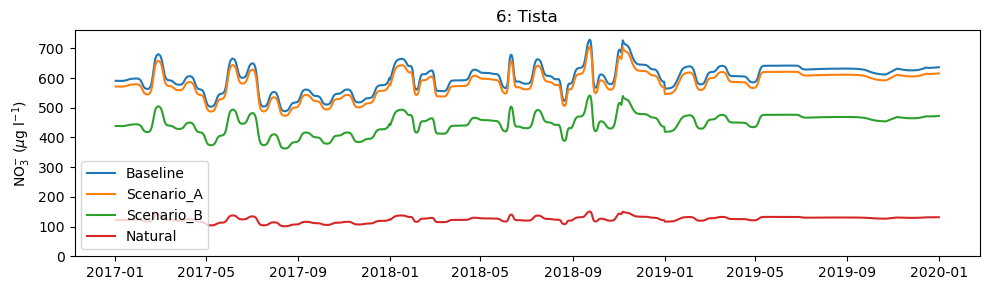

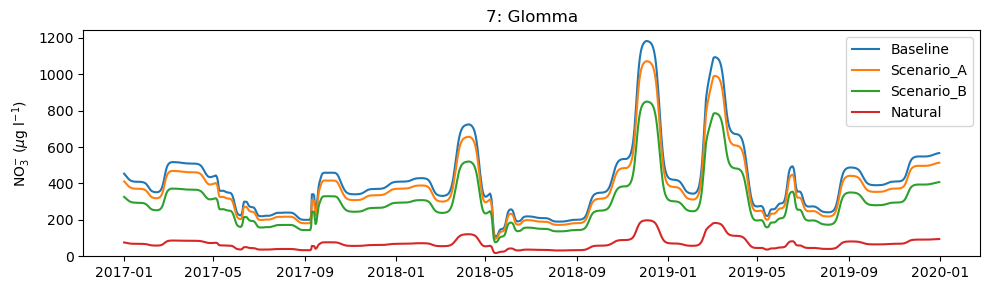

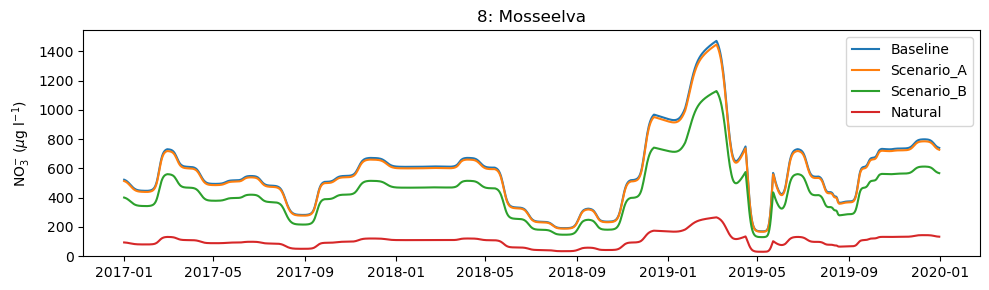

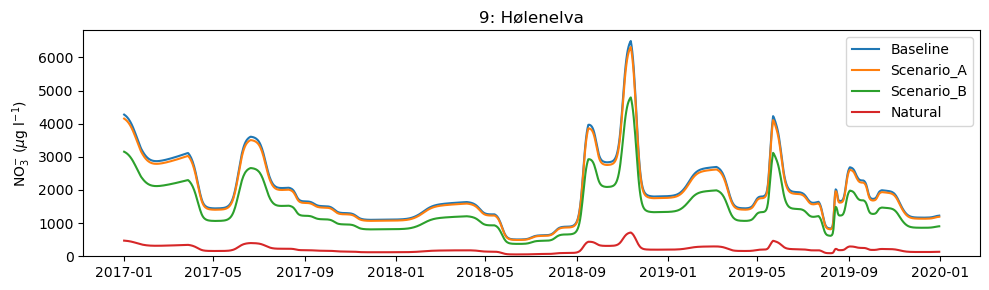

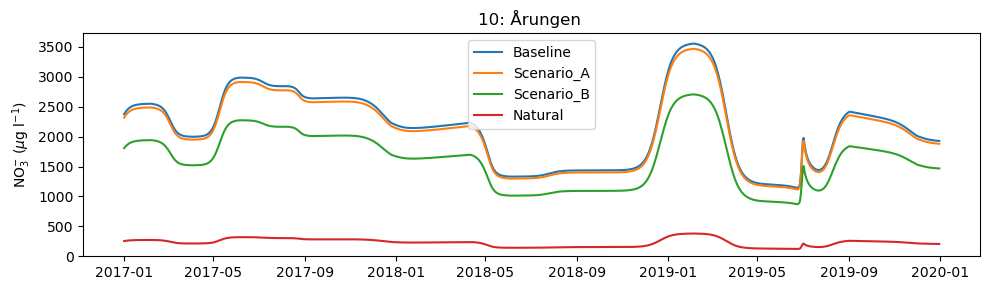

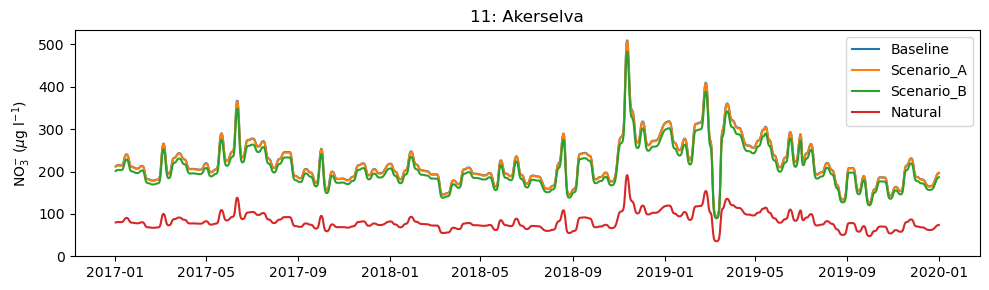

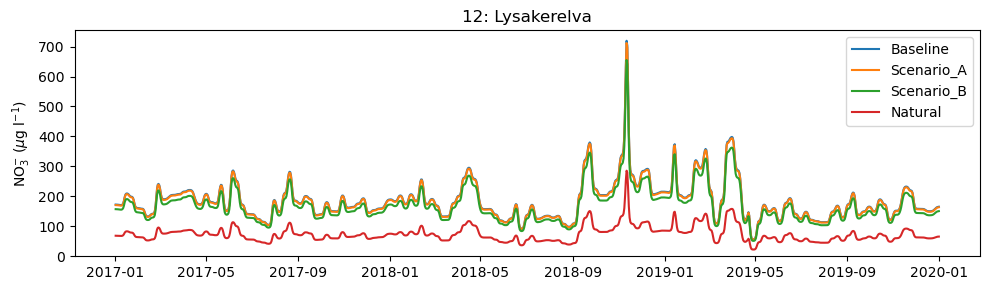

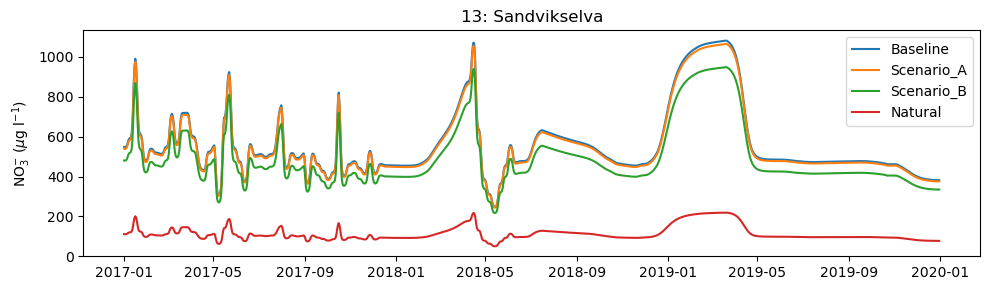

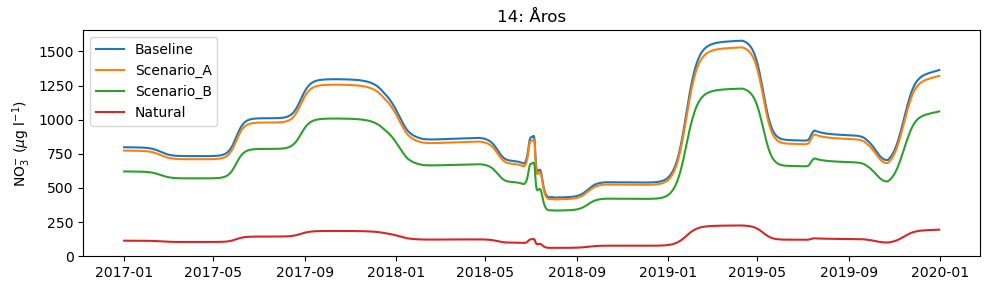

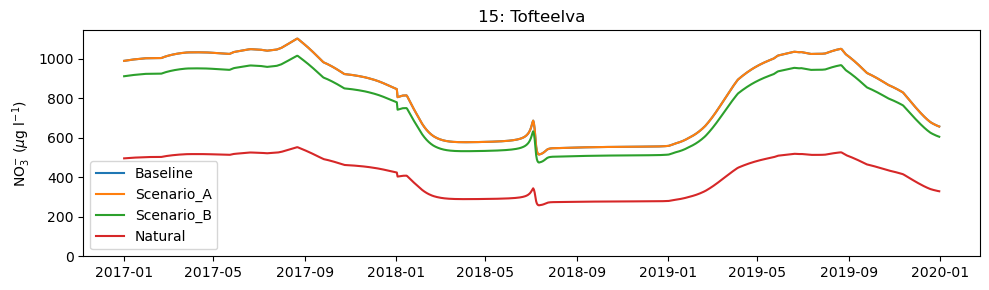

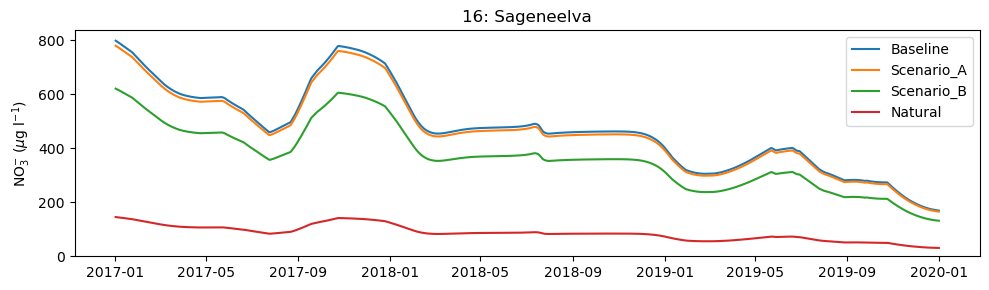

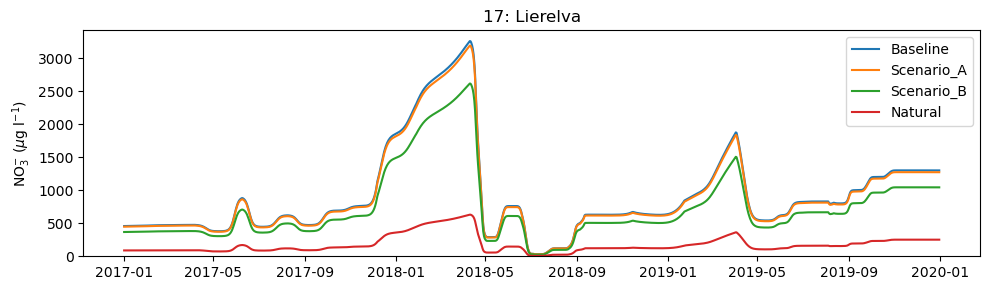

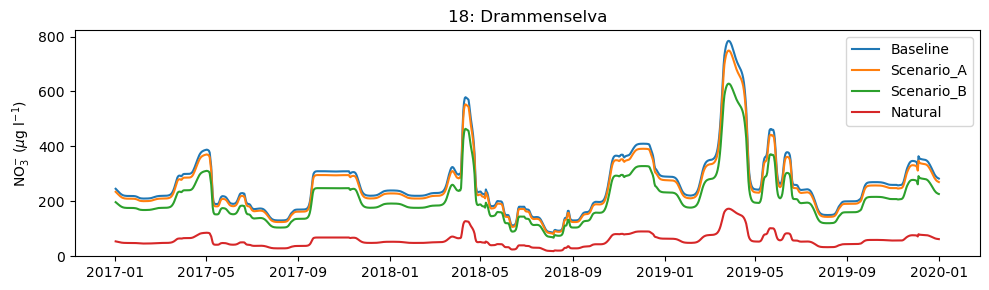

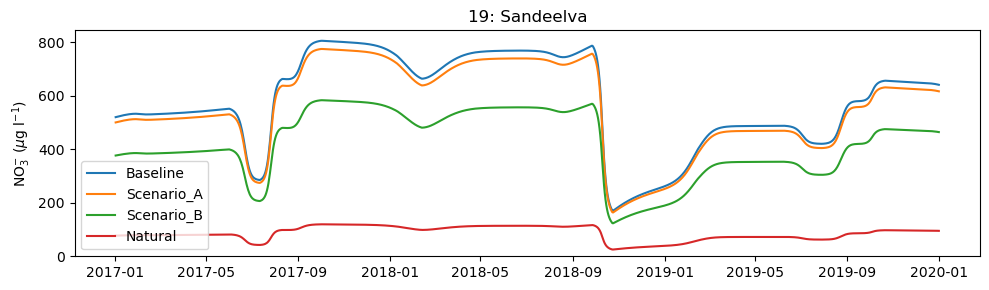

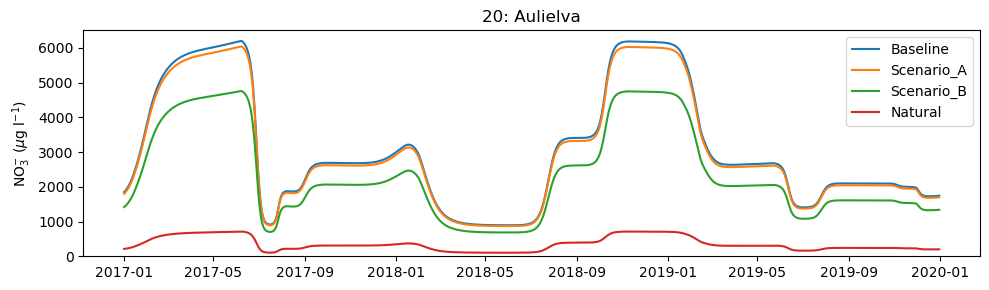

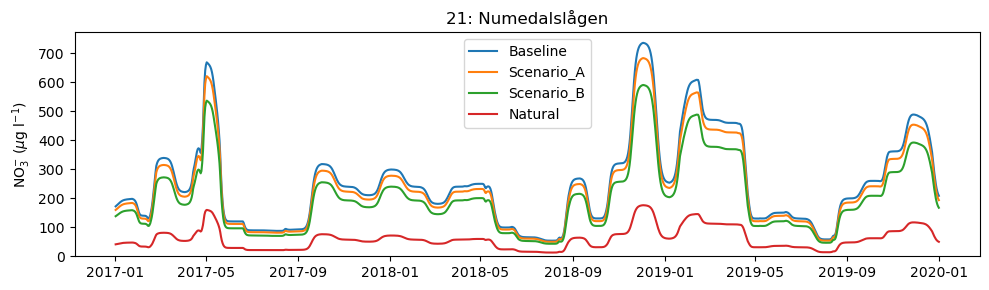

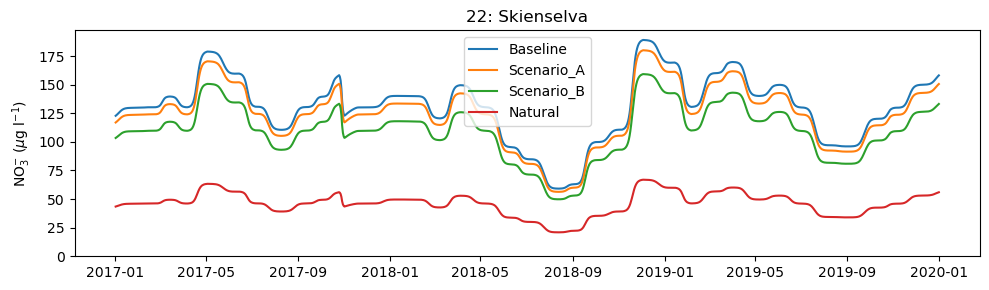

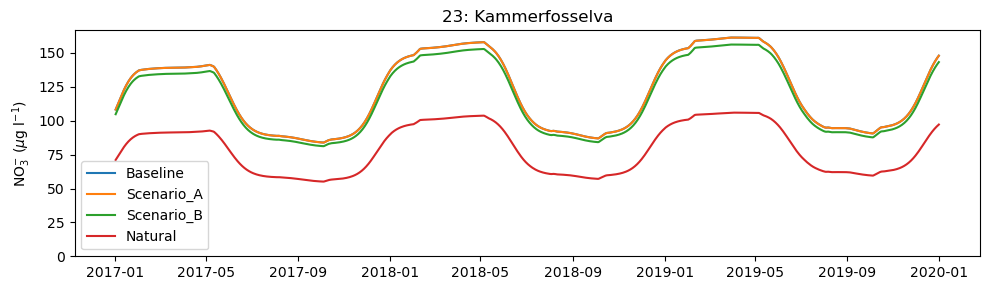

In [37]:
var = "river_NO3NO2N"

ylabel_dict = {"river_NO3NO2N": r'NO$_3^{−}$ ($\mu$g l$^{-1}$)'}

ds_bsl = xr.open_dataset(fpath_baseline_data)
ds_bsl = ds_bsl.sel(river_time=slice(start_date, end_date))

for riv_no in oslofjord_riv_nos:
    riv_name = river_meta_df.loc[riv_no, "river_name"]
    fig, ax = plt.subplots(figsize=(10, 3))  # Create a new figure and axes for each river

    # Plot the baseline
    plot_bsl_ds = ds_bsl.sel(real_river=riv_no)
    ax.plot(plot_bsl_ds["river_time"].values, plot_bsl_ds[var].values, label="Baseline")

    # Plot scenarios
    for scenario in scenario_list:
        plot_scen_ds = ds_scen_dict[scenario].copy().sel(real_river=riv_no)
        ax.plot(plot_scen_ds["river_time"].values, plot_scen_ds[var].values, label=scenario)

    ax.set_ylabel(ylabel_dict[var])
    ax.set_ylim(ymin=0)
    ax.legend()
    ax.set_title(f'{riv_no}: {riv_name}')
    plt.tight_layout()

    fpath = os.path.join(fig_folder, "concentration_timeseries", f"scenario_ts_{riv_name}_{var}_v{v}.png")
    plt.savefig(fpath)
    plt.show()

# Exploring which sectors the load reduction comes from

In [27]:
# For the baseline, calculate the proportion each sector makes to the total,
# averaged over all the years of interest, for each parameter

bsl_f_sector_df_dict = {}  # key: par, returns baseline contribution per sector

for par in t3_par_list:

    # Total accumulated input per regine from all sources
    bsl_teotil_av_df = teotil_av_df_dict[('Baseline', par)].copy()
    teotil_total_s = bsl_teotil_av_df.sum(axis=1)

    # Proportion per regine and source (checked that rows sum to 1, they do)
    tmp_f_sector_df = bsl_teotil_av_df.divide(teotil_total_s, axis=0)
    # print(f_sector_df.sum(axis=1).tail())

    # Remove any rows where real_river=NaN, i.e. Sweden (if present)
    tmp_f_sector_df = tmp_f_sector_df.reset_index().dropna(subset=['real_river']).set_index('real_river')

    # Select just the rivers of interest in the current domain
    tmp_f_sector_df = tmp_f_sector_df[tmp_f_sector_df.index.isin(oslofjord_riv_nos)]

    # # Also calculate total flux over all rivers
    # # Add as another row to f_sector_df with index='Total'
    # total_flux = bsl_teotil_av_df.sum().sum()
    # tmp_f_sector_df.loc['Total'] = bsl_teotil_av_df.sum(axis=0) / total_flux

    # print(par)
    # print((tmp_f_sector_df.loc['Total', :] * 100).round(1))
    # print("--------------------")

    bsl_f_sector_df_dict[par] = tmp_f_sector_df

# Quick check
bsl_f_sector_df_dict['din'].head()

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
real_river,,,,,,,,,,
6.0,0.069869,0.628824,0.0,0.061602,0.081062,0.054487,0.024172,0.002830,0.024215,0.052939
7.0,0.069815,0.628338,0.0,0.000368,0.029196,0.150490,0.025516,0.021456,0.028134,0.046687
8.0,0.081426,0.732836,0.0,0.000000,0.050304,0.014471,0.024720,0.000956,0.047236,0.048051
9.0,0.089419,0.804771,0.0,0.000000,0.000575,0.012188,0.029506,0.000303,0.043065,0.020172
10.0,0.092807,0.835261,0.0,0.000000,0.007394,0.001230,0.018651,0.000124,0.037882,0.006651


In [26]:
# Calculate factor reductions per scenario, split by sector and real river

f_sector_red_df_dict = {}  # key: (scenario, teotil par). Returns: df, real_river index, one col per source, scen/bsl

# List of sectors where change factors != 1
sector_cols = []

for scenario in scenario_list:
    for par in t3_par_list:
        f_red_df = teotil_av_df_dict[(scenario, par)] / teotil_av_df_dict[('Baseline', par)]

        # Have some NaNs (when baseline = 0). Replace any NaNs with 1 (i.e. no change)
        f_red_df.replace([np.inf, -np.inf], 1, inplace=True)
        f_red_df.fillna(1, inplace=True)

        f_sector_red_df_dict[(scenario, par)] = f_red_df

        # Populate change_sectors list
        changed_cols = [col for col in f_red_df.columns if (f_red_df[col] != 1).any()]
        sector_cols.append(changed_cols)

# Make the sector_cols list
# Flatten the list
sector_cols = [item for sublist in sector_cols for item in sublist]
# Drop duplicates
sector_cols = list(set(sector_cols))

print("Sectors updated in the scenarios for at least one of the Teotil3 params:")
print(sector_cols)

Sectors updated in the scenarios for at least one of the Teotil3 params:
['large-wastewater', 'agriculture', 'agriculture-background']


In [20]:
f_sector_red_df_dict[('Scenario_A', 'din')].round(3)

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
real_river,,,,,,,,,,
6.0,0.980,0.980,1.0,1.0,1.0,0.659,1.0,1.0,1.0,1.0
7.0,0.986,0.986,1.0,1.0,1.0,0.440,1.0,1.0,1.0,1.0
8.0,0.979,0.979,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0
9.0,0.968,0.968,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0
10.0,0.974,0.974,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0
11.0,0.979,0.979,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0
12.0,0.973,0.973,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0
13.0,0.971,0.971,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0
14.0,0.958,0.958,1.0,1.0,1.0,1.000,1.0,1.0,1.0,1.0


In [70]:
# Calculate total load removed per scenario, split by sector and real river
# Units: T/yr

sector_load_red_dict = {}  # key: (scenario, teotil par). Returns: df, real_river index, one col per source, scen/bsl

for scenario in scenario_list:
    for par in t3_par_list:
        load_red_df = (teotil_av_df_dict[('Baseline', par)] - teotil_av_df_dict[(scenario, par)]) / 1000.0

        sector_load_red_dict[(scenario, par)] = load_red_df

# Quick check
sector_load_red_dict[('Scenario_A', 'ss')].head()

,agriculture-background,agriculture,glacier,industry,large-wastewater,spredt,upland,urban,wood
real_river,,,,,,,,,
6.000,0.000,235.256,0.000,0.000,0.001,0.000,0.000,0.000,0.000
7.000,0.000,100054.268,0.000,0.000,111.205,0.000,0.000,0.000,0.000
8.000,0.000,327.113,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9.000,0.000,4941.110,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10.000,0.000,188.513,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [75]:
# Calculate overall reduction factor, averaged over sector (taking proportion
# contribution per sector into account)

# Disable scientific notation for floating point numbers
pd.set_option('display.float_format', '{:.3f}'.format)


# Reduction factors are multiplicative, i.e. new conc = baseline conc * factor

# Also make scenario summary table

rename_f_sector_dict = {'agriculture': 'f_jordbruk',
                        'large-wastewater': 'f_ra',
                        'agriculture-background': 'f_jordbruk-bakgrunn'}

rename_f_red_dict = {'agriculture': 'f-red_jordbruk',
                     'large-wastewater': 'f-red_ra',
                     'agriculture-background': 'f-red_jordbruk-bakgrunn'}

rename_load_red_dict = {'agriculture': 'load_reduction_jordbruk_T-per-yr',
                        'large-wastewater': 'load_reduction_ra_T-per-yr',
                        'agriculture-background': 'load_reduction_jordbruk-bakgrunn_T-per-yr'}

scen_summary_df_dict = {}  # key: (scenario, par). Includes total reduction factor

for scenario in scenario_list:
    for par in t3_par_list:

        # Baseline proportion of total load from the sectors of interest
        scen_summary_df = bsl_f_sector_df_dict[(par)][sector_cols].copy()
        scen_summary_df = scen_summary_df.rename(rename_f_sector_dict, axis=1)

        # Reduction factors for the sectors of interest
        f_red_df = f_sector_red_df_dict[(scenario, par)][sector_cols].copy()
        f_red_df = f_red_df.rename(rename_f_red_dict, axis=1)
        scen_summary_df = scen_summary_df.join(f_red_df)

        # Also load reductions per sector (T/yr)
        load_red_df = sector_load_red_dict[(scenario, par)][sector_cols].copy()
        load_red_df = load_red_df.rename(rename_load_red_dict, axis=1)
        scen_summary_df = scen_summary_df.join(load_red_df)

        # Calculate f-red_total
        # N.B. this is long-winded. TODO: replace with calc directly from total loads in
        # scenarios and baseline. But below is good for validation. Get same result.
        # Dynamically calculate f-red_total the long-winded way, for validation of all component parts
        included_p_sum = 0
        f_red_total = 0

        for sector in sector_cols:
            p_i = scen_summary_df[rename_f_sector_dict[sector]]
            f_i = scen_summary_df[rename_f_red_dict[sector]]
            f_red_total += p_i * f_i
            included_p_sum += p_i

        # Add excluded sectors with f_i = 1
        remaining_p_sum = 1 - included_p_sum
        f_red_total += remaining_p_sum

        scen_summary_df['f-red_total'] = f_red_total

        # Add in total load per river, baseline & scenario, to calculate new totals for whole OF
        bsl_load_series = teotil_av_df_dict[('Baseline', par)].sum(axis=1) / 1000
        scen_load_series = teotil_av_df_dict[(scenario, par)].sum(axis=1) / 1000
        scen_summary_df["Bsl_Teotil3_hovedelv_load_T-per-yr"] = scen_summary_df.index.map(bsl_load_series)
        scen_summary_df[f"{scenario}_Teotil3_hovedelv_load_T-per-yr"] = scen_summary_df.index.map(scen_load_series)

        # Add explicit percent and total load reduction columns, for clarity
        scen_summary_df['Total reduction (%)'] = (100 * (1 - scen_summary_df['f-red_total'])).round(2)
        scen_summary_df['Total reduction (T/yr)'] = scen_summary_df['Bsl_Teotil3_hovedelv_load_T-per-yr'] - scen_summary_df[f"{scenario}_Teotil3_hovedelv_load_T-per-yr"]

        # Add river name
        scen_summary_df['river_name'] = scen_summary_df.index.map(river_meta_df['river_name'])

        # Reorder cols
        first_cols = ['river_name']
        scen_summary_df = scen_summary_df[first_cols + [col for col in scen_summary_df.columns if col not in first_cols]]

        # Save for calculating new daily concentrations
        scen_summary_df_dict[(scenario, par)] = scen_summary_df

        # Save to csv
        fpath = os.path.join(summary_csv_folder, f"hovedelv_reductions_by_sector_{scenario}-{par}.csv")
        scen_summary_df.to_csv(fpath, index=True)

    # ------------ Make single long df-----------------
    # dfs_list = []

    # for key, df in scen_summary_df_dict.items():
    #     df['Teotil3 parameter'] = key[1]
    #     dfs_list.append(df)

    # scen_summary_df = pd.concat(dfs_list, ignore_index=False).reset_index()

    # Reorder cols
    # first_cols = ['real_river', 'river_name', 'Teotil3 parameter']
    # scen_summary_df = scen_summary_df[first_cols + [col for col in scen_summary_df.columns if col not in first_cols]]

In [74]:
scen_summary_df_dict[('Scenario_A', 'din')]

,river_name,f_ra,f_jordbruk,f_jordbruk-bakgrunn,f-red_ra,f-red_jordbruk,f-red_jordbruk-bakgrunn,load_reduction_ra_T-per-yr,load_reduction_jordbruk_T-per-yr,load_reduction_jordbruk-bakgrunn_T-per-yr,f-red_total,Bsl_Teotil3_hovedelv_load_T-per-yr,Scenario_A_Teotil3_hovedelv_load_T-per-yr,Total reduction (%),Total reduction (T/yr)
real_river,,,,,,,,,,,,,,,
6.000,Tista,0.054,0.629,0.070,0.659,0.980,0.980,6.908,4.634,0.515,0.968,371.447,359.390,3.250,12.057
7.000,Glomma,0.150,0.628,0.070,0.440,0.986,0.986,804.682,81.832,9.092,0.906,9543.466,8647.860,9.380,895.607
8.000,Mosseelva,0.014,0.733,0.081,1.000,0.979,0.979,0.000,3.610,0.401,0.983,235.298,231.287,1.700,4.011
9.000,Hølenelva,0.012,0.805,0.089,1.000,0.968,0.968,0.000,4.454,0.495,0.972,175.335,170.386,2.820,4.949
10.000,Årungen,0.001,0.835,0.093,1.000,0.974,0.974,0.000,1.352,0.150,0.976,61.800,60.297,2.430,1.503
11.000,Akerselva,0.000,0.174,0.019,1.000,0.979,0.979,0.000,0.134,0.015,0.996,36.979,36.830,0.400,0.149
12.000,Lysakerelva,0.000,0.355,0.039,1.000,0.973,0.973,0.000,0.321,0.036,0.989,33.832,33.475,1.050,0.357
13.000,Sandvikselva,0.006,0.476,0.053,1.000,0.971,0.971,0.000,0.963,0.107,0.985,69.879,68.809,1.530,1.070
14.000,Åros,0.000,0.669,0.074,1.000,0.958,0.958,0.000,1.946,0.216,0.969,69.772,67.610,3.100,2.162
